In [1]:
import os
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

2022-11-18 21:42:42.725218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 21:42:43.193025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 21:42:43.193067: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-18 21:42:43.279597: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 21:42:45.136403: W tensorflow/stream_executor/platform/de

In [2]:
train_dir = 'dataset_reducida/train'
validation_dir = 'dataset_reducida/validation'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')  # with data augmentation for train set

valid_datagen = ImageDataGenerator(rescale=1./255)  # no augmentation for validation set

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))


validation_generator = valid_datagen.flow_from_directory(validation_dir,
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         target_size=(224, 224))


Found 1847 images belonging to 3 classes.
Found 452 images belonging to 3 classes.


In [3]:
pasos_entrenamiento = train_generator.n//train_generator.batch_size
pasos_validacion = validation_generator.n//validation_generator.batch_size

In [4]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.99 and logs.get('val_acc') > 0.99):
            print("\nCancelling training as model has reached 99% accuracy and 99% validation accuracy!")
            self.model.stop_training = True


In [5]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    plt.savefig("plot.png")


In [6]:
# Download Inception v3 weights to local machine
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import Inception v3 Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights=None)

# Load Inception v3 weights into model
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model.load_weights(local_weights_file)

--2022-11-18 21:42:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Cargado certificado CA '/etc/ssl/certs/ca-certificates.crt'
Resolviendo storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4003:c08::80, 2800:3f0:4003:c01::80, 2800:3f0:4003:c00::80, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[2800:3f0:4003:c08::80]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 87910968 (84M) [application/x-hdf]
Grabando a: «/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5»

/tmp/inception_v3_w 100%[===================>]  83,84M  16,9MB/s    en 6,2s    

2022-11-18 21:42:54 (13,5 MB/s) - «/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5» guardado [87910968/87910968]



2022-11-18 21:42:55.048868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-18 21:42:55.048911: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-18 21:42:55.048933: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (machine): /proc/driver/nvidia/version does not exist
2022-11-18 21:42:55.049221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [8]:
pre_trained_model.summary()
plot_model(pre_trained_model, to_file='inception_v3_model.png', show_shapes=False, show_layer_names=True)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [14]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [15]:
img_width, img_height = 224, 224

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

inputs = layers.Input(shape=input_shape)

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(3, activation='softmax')(x)

model = Model(pre_trained_model.input, x)


In [16]:
model.summary()
plot_model(model, to_file='inception_v3_with_dense_layers_model.png', show_shapes=False, show_layer_names=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [17]:
model.compile(loss='categorical_crossentropy',
           optimizer=optimizers.Adam(lr=0.0005),
           metrics=['accuracy'])
H = model.fit_generator(
    train_generator,
    steps_per_epoch=pasos_entrenamiento,
    epochs = 11,
    validation_data = validation_generator,
    validation_steps= pasos_validacion)

/tmp/ipykernel_4707/2104208323.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/11
57/57 [==============================] - 173s 3s/step - loss: 2.0963 - accuracy: 0.6116 - val_loss: 0.9444 - val_accuracy: 0.7031
Epoch 2/11
57/57 [==============================] - 169s 3s/step - loss: 0.6460 - accuracy: 0.7218 - val_loss: 0.4784 - val_accuracy: 0.7924
Epoch 3/11
57/57 [==============================] - 169s 3s/step - loss: 0.5838 - accuracy: 0.7537 - val_loss: 0.5086 - val_accuracy: 0.7746
Epoch 4/11
57/57 [==============================] - 168s 3s/step - loss: 0.5532 - accuracy: 0.7658 - val_loss: 0.4524 - val_accuracy: 0.8013
Epoch 5/11
57/57 [==============================] - 169s 3s/step - loss: 0.5593 - accuracy: 0.7565 - val_loss: 0.4345 - val_accuracy: 0.8013
Epoch 6/11
57/57 [==============================] - 172s 3s/step - loss: 0.5111 - accuracy: 0.7829 - val_loss: 0.4014 - val_accuracy: 0.8326
Epoch 7/11
57/57 [==============================] - 162s 3s/step - loss: 0.5004 - accuracy: 0.7813 - val_loss: 0.5445 - val_accuracy: 0.7656
Epoch 8/11
57

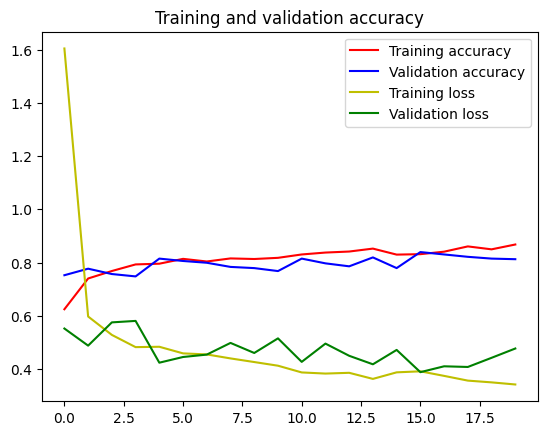

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
plot_result(H)
